<a href="https://colab.research.google.com/github/AkiraNom/data-analysis-notebook/blob/main/Capture_and_Recapture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The capture-mark-recapture (CMR) method is a common way to estimate the population size of animal in a region. Briefly, animals are captured using a trap which harmlessly collects animal hairs. Using DNA data from the hair, the researchers identify individual animals. See the experimental description in [the article](https://www.researchgate.net/publication/229195465_Estimating_Population_Size_of_Grizzly_Bears_Using_Hair_Capture_DNA_Profiling_and_Mark-Recapture_Analysis).



Observation data:
> $Number$: number of unique animals captured <br>
>$Recapture$: number of recaptures

|Year|Number|Recapture|
|----|-|--|
|2007|140|45|
|2008|183|62|

[collection_data](https://besjournals.onlinelibrary.wiley.com/doi/full/10.1111/2041-210X.12202) by Birtd et al., 2014. This article provides a method to diminish bias due to temporary migration.

## Two-parameter Model

I will try a model with two parameters: the number of aniamals, `N`, and the probability of observing an animal, `p`.



In [1]:
import pandas as pd
import numpy as np
from scipy.stats import uniform
from scipy.stats import multinomial
import matplotlib.pyplot as plt
from seaborn import JointGrid

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

from empiricaldist import Pmf

## $N$ and $p$ estimation
Assume that we do not have any prior information on the local population size and observation probability, I will use a *uniform distribution* ranging from 500 to 1000 for the local population size and from 0 to 0.99 for the observation probability.

In [3]:
def make_uniform(qs, name=None, **options):
    """Make a Pmf that represents a uniform distribution."""
    pmf = Pmf(1.0, qs, **options)
    pmf.normalize()
    if name:
        pmf.index.name = name
    return pmf

In [4]:
qs = np.arange(500, 1001)
prior_N = make_uniform(qs, name='N')

qs = np.linspace(0, 0.99, num=100)
prior_p = make_uniform(qs, name='p')

In [5]:
# make a joint distribution
X, Y = np.meshgrid(prior_p, prior_N)
joint_prior = pd.DataFrame(X * Y, columns=prior_p.qs, index=prior_N.qs)
joint_prior.index.names=['N']
joint_prior.columns.names=['p']

In [6]:
joint_pmf = Pmf(joint_prior.stack())
joint_pmf.head()

N    p   
500  0.00    0.00002
     0.01    0.00002
     0.02    0.00002
Name: , dtype: float64

## Update the prior with observation data


## multinomial distribution

The probability of observing an animal is modeled with the multinomial distribution
$$\frac{N!}{\prod x_i!} \prod y_i^{x_i}$$

>$N$: actual population <br>
>$x$: counts in each category <br>
>$y$: probability in each category <br>

* `k10` is the number of animals observed in the first study but not the second,

* `k01` is the number of animals observed in the second study but not the first, and

* `k11` is the number of animals observed in both studies.
<br>

|Year|Number|Recapture|
|----|-|--|
|2007|140|45|
|2008|183|62|

<br>
I set the 2007 data as the first study and the 2008 data as the second study. Therefore, I assume 185 (140+45) as the initial observed animals.  

In [7]:
k11 = 62
k01 = 183
k10 = 140+45-k11

In [8]:
observed = k01 + k10 + k11
likelihood = joint_pmf.copy()
for N, p in joint_pmf.index:
    k00 = N - observed
    x = [k00, k01, k10, k11]
    q = 1-p
    y = [q*q, q*p, p*q, p*p]
    likelihood[N, p] = multinomial.pmf(x, N, y)

In [9]:
posterior_pmf = joint_pmf * likelihood
posterior_pmf.normalize()

2.0027985687163962e-09

In [10]:
joint_posterior = posterior_pmf.unstack()

In [11]:
def contour_plot(joint_dist):
  low = joint_dist.to_numpy().min()
  high = joint_dist.to_numpy().max()
  levels = np.linspace(low, high, 6)
  levels = levels[1:] # determine the number and the positions of the contour lines/regions

  x_label = joint_dist.columns.name
  y_label = joint_dist.index.name
  fig = plt.contour(joint_dist.columns, joint_dist.index, joint_dist, levels=levels)
  plt.xlabel(f'{x_label}')
  plt.ylabel(f'{y_label}')
  plt.title(f'Joint posterior distribution of {x_label}and {y_label}')

  return fig

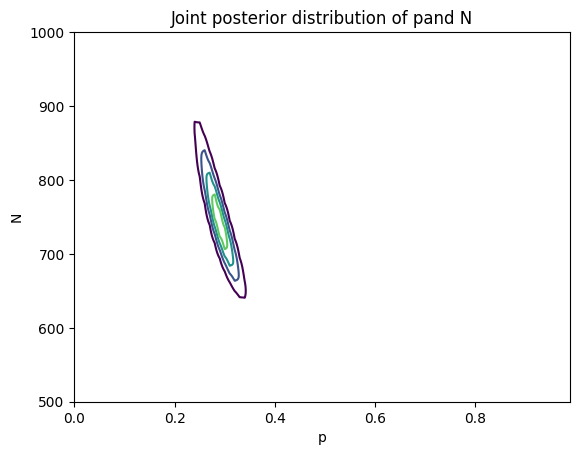

In [12]:
contour_plot(joint_posterior)

Based on the contour plot, the population size is around 750 and the p is almost 0.3.

**Joint posterior distribution** represents that the possible range of `N` and `p` given the prior distribution and the observed data. <br>
<br>
**Margianl distribution** is the distribution of a single variable from a joint distribution.

In [13]:
def marginal(joint, axis):
    """Compute a marginal distribution."""
    return Pmf(joint.sum(axis=axis))

Extract the margianl distribution of p and N

In [14]:
posterior_p = marginal(joint_posterior, 0)
posterior_N = marginal(joint_posterior, 1)

<Axes: title={'center': 'Posterior marginal distribution of p'}, xlabel='p', ylabel='PDF'>

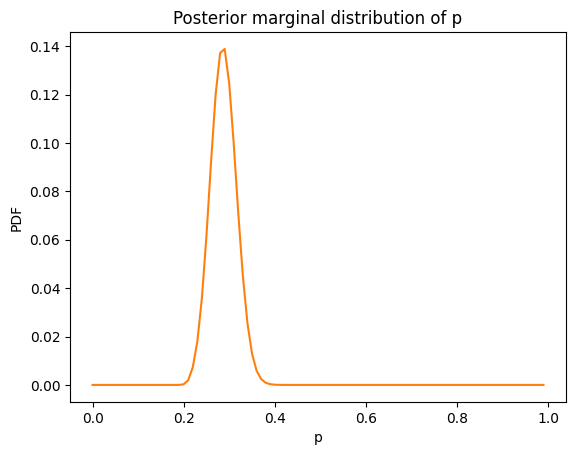

In [15]:
posterior_p.plot(color='C1',
                  title='Posterior marginal distribution of p',
                  ylabel='PDF')

<Axes: title={'center': 'Posterior marginal distribution of N'}, xlabel='N', ylabel='PDF'>

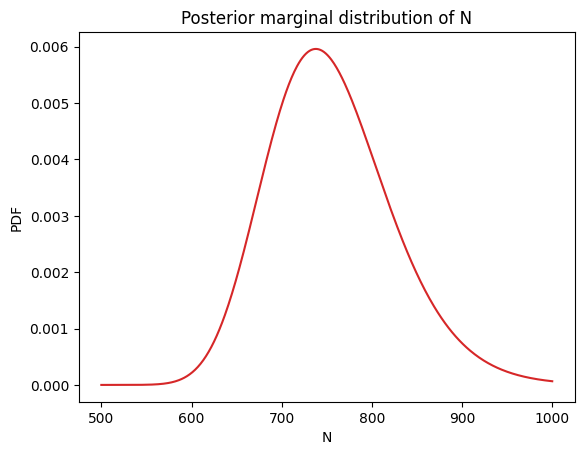

In [16]:
posterior_N.plot(color='C3',
                  title='Posterior marginal distribution of N',
                  ylabel='PDF')

In [17]:
print(f'Mean population size is {posterior_N.mean(): .2f}\
       \n90% confidence interval is {posterior_N.credible_interval(0.9)}')

Mean population size is  754.86       
90% confidence interval is [652. 878.]
